<a href="https://colab.research.google.com/github/sakeefkarim/pop-class/blob/main/analysis/Radicalization_GOP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mainstreaming of the Far Right in 21st Century Party Politics

Sakeef M. Karim and Martin Lukk

Loading _essential_ packages and submodules:

In [1]:
# For data manipulation:

import pandas as pd

import numpy as np

# For model training, validation, hyperparameter tuning etc.:

from sklearn.model_selection import cross_val_score, RepeatedKFold, StratifiedKFold, KFold, train_test_split, GridSearchCV

# Assessment of model performance:

from sklearn.metrics import precision_score, recall_score, f1_score, brier_score_loss, RocCurveDisplay

# To facilitate interpretation:

from sklearn.inspection import PartialDependenceDisplay

# Adjusting basic plots:

import matplotlib.pyplot as plt

import seaborn as sns

sns.set(style='darkgrid')

Programmatically mounting Drive folder:

In [ ]:
# If you want to load/save files via Google Drive:

from google.colab import drive
drive.mount('/drive')

Mounted at /drive


Introducing submodules for random forest estimation:

In [2]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV

from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.over_sampling import SMOTE

Loading the data:

In [4]:
# Data frame with *only* the latest "year" for every party:

vparty = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/vparty_latest.csv').dropna()

,country_name,farright,v2paanteli,v2papeople,v2paopresp,v2paplur,v2paminor,v2paviol,v2paimmig,v2palgbt,v2paculsup,v2parelig,v2pagender,v2pawomlab,v2pariglef,v2pawelf,v2paclient
0,Austria,1,2.638,0.711,-1.810,0.481,-0.456,1.671,-4.238,-0.648,-2.882,-0.910,-0.604,-1.441,1.447,-0.500,-0.717
1,Austria,1,1.281,-0.357,-1.545,0.407,0.282,1.722,-1.413,0.091,-0.514,0.879,-0.626,-0.353,1.948,-1.842,-1.317
2,Austria,0,0.291,-2.075,1.879,1.882,2.494,1.717,1.546,2.606,2.881,1.758,2.219,2.677,1.085,-0.569,-1.784
3,Austria,0,-1.011,-1.656,0.979,1.842,0.798,1.661,-1.827,0.936,0.296,-0.065,1.868,-1.473,0.854,-0.698,-0.717
4,Austria,0,-0.608,-2.067,-0.167,1.846,1.703,1.705,-0.216,1.939,1.362,1.782,1.496,0.995,-0.182,2.384,-0.978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
467,United Kingdom,1,1.943,2.882,-1.711,0.762,-2.172,0.541,-3.602,-0.383,-0.634,0.998,-0.778,-1.725,2.539,-1.412,-2.376
468,United Kingdom,0,0.459,0.556,-0.318,1.450,1.081,1.749,1.447,1.685,-0.317,1.778,2.581,1.315,-1.985,1.831,-0.857
469,United Kingdom,0,-0.647,-0.221,0.319,1.387,1.452,1.720,2.380,3.289,1.500,1.777,2.559,2.751,-0.165,0.011,-2.403
470,United Kingdom,0,-0.043,1.448,-0.967,1.404,1.077,1.779,1.104,2.397,0.806,1.751,2.101,2.746,-2.474,1.726,-1.570


Random forest estimation:

In [5]:
# Target:

y = vparty['farright']

# Features:

X = vparty.drop(columns = ['country_name', 'farright'])

# Basic train-test split:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 416)

# Growing a random forest of decorrelated decision trees:

rf = RandomForestClassifier(n_estimators=1000, class_weight='balanced_subsample')

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=1000)

Model assessment:

Test Score: 0.95
F1 Score: 0.7999999999999999


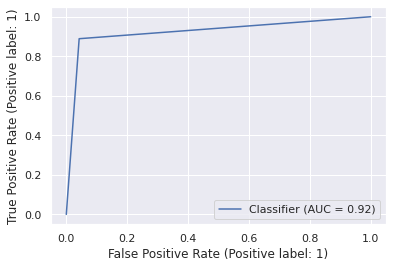

In [6]:
print("Test Score: {}".format(rf.score(X_test, y_test)))

y_pred = rf.predict(X_test)

print("F1 Score: {}".format(f1_score(y_test, y_pred)))

RocCurveDisplay.from_predictions(y_test, y_pred)

Bringing in _relatively_ balanced data frame:

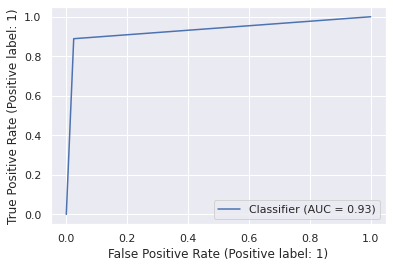

In [16]:
vparty_alt = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/vparty_earliest_balanced.csv').dropna()

# Target:

y_balance = vparty_alt['farright']

# Features:

X_balance = vparty_alt.drop(columns = ['country_name', 'farright'])

# Applying random forest to relatively balanced data frame (unseen data):

rf.score(X_balance, y_balance)

f1_score(y_balance, rf.predict(X_balance))

RocCurveDisplay.from_predictions(y_balance, rf.predict(X_balance))

Calibration:

0.05
0.0375


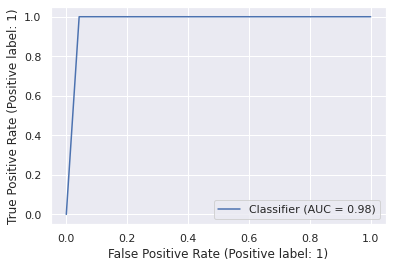

In [17]:
calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=3)

calibrated.fit(X_train, y_train)

calibrated.score(X_test, y_test)

cal_predict = calibrated.predict(X_test)

f1_score(y_test, cal_predict)

print(brier_score_loss(y_test, y_pred))

print(brier_score_loss(y_test, cal_predict))


RocCurveDisplay.from_predictions(y_test, calibrated.predict(X_test))


## Radicalization of the Republican Party (and the BJP, too?)

In [18]:
# The Grand Old Party:

gop = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/not%20in%20populist/grand_old_party.csv').dropna()

gop_variables = gop.drop(columns=['country_name', 'party_year'])

# Comparison: The Democrats

dems = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/not%20in%20populist/democrats.csv').dropna()

dems_variables = dems.drop(columns=['country_name', 'party_year'])

# Comparison: The BJP

bjp = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/not%20in%20populist/bjp.csv').dropna()

bjp_variables = bjp.drop(columns=['country_name', 'party_year'])


# Comparison: Likud in Israel

likud = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/not%20in%20populist/likud.csv').dropna()

likud_variables = likud.drop(columns=['country_name', 'party_year'])


In [19]:
# Republican Party Over Time: Probability of Being "Far Right"

calibrated.predict_proba(gop_variables)

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.99382716, 0.00617284],
       [1.        , 0.        ],
       [0.95833333, 0.04166667],
       [0.91666667, 0.08333333],
       [0.93062265, 0.06937735],
       [0.93525228, 0.06474772],
       [0.2037037 , 0.7962963 ],
       [0.2037037 , 0.7962963 ]])

In [20]:
# What about Dems?

calibrated.predict_proba(dems_variables)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [21]:
# The BJP?

# Similar shift under Narenda Modi:

calibrated.predict_proba(bjp_variables)

array([[0.78055556, 0.21944444],
       [0.78055556, 0.21944444],
       [0.82920021, 0.17079979],
       [0.83866076, 0.16133924],
       [0.82403382, 0.17596618],
       [0.83731884, 0.16268116],
       [0.78055556, 0.21944444],
       [0.2037037 , 0.7962963 ],
       [0.2037037 , 0.7962963 ]])

In [22]:
# Likud in Israel

calibrated.predict_proba(likud_variables)

array([[1.        , 0.        ],
       [1.        , 0.        ],
       [0.95833333, 0.04166667],
       [0.95833333, 0.04166667],
       [0.95833333, 0.04166667],
       [1.        , 0.        ],
       [0.95524691, 0.04475309],
       [0.83333333, 0.16666667],
       [0.78412698, 0.21587302]])

In [23]:
# Alternative for Germany?

vparty_original = pd.read_csv('https://github.com/martinlukk/pop-class/raw/main/data/vparty_original.csv').dropna()

vparty_original_variables = vparty_original.drop(columns=['country_name', 'farright', 'party_id'])

calibrated.predict_proba(vparty_original_variables.loc[592:593,])

array([[0.03703704, 0.96296296],
       [0.        , 1.        ]])

## Interpreting Results

In [24]:
importance = rf.feature_importances_

#
# Sort feature importances in descending order
#

sorted_indices = np.argsort(importance)[::-1]
 
feat_labels = X.columns
 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            importance[sorted_indices[f]]))

 1) v2paimmig                      0.262645
 2) v2paculsup                     0.160706
 3) v2paanteli                     0.114949
 4) v2paminor                      0.087572
 5) v2papeople                     0.062382
 6) v2paplur                       0.048013
 7) v2pawomlab                     0.047934
 8) v2palgbt                       0.043164
 9) v2paopresp                     0.041837
10) v2pariglef                     0.032662
11) v2paviol                       0.029154
12) v2pagender                     0.024455
13) v2pawelf                       0.020316
14) v2parelig                      0.012704
15) v2paclient                     0.011507


In [25]:
# For calirbated classifier:

feat_imp = 0

for i in calibrated.calibrated_classifiers_:
    feat_imp = feat_imp + i.base_estimator.feature_importances_
feat_imp  = feat_imp/len(calibrated.calibrated_classifiers_)

feat_imp


for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[sorted_indices[f]],
                            feat_imp[sorted_indices[f]]))

 1) v2paimmig                      0.259938
 2) v2paculsup                     0.157082
 3) v2paanteli                     0.119847
 4) v2paminor                      0.093503
 5) v2papeople                     0.052063
 6) v2paplur                       0.046815
 7) v2pawomlab                     0.053292
 8) v2palgbt                       0.047033
 9) v2paopresp                     0.039594
10) v2pariglef                     0.036651
11) v2paviol                       0.027597
12) v2pagender                     0.023240
13) v2pawelf                       0.018078
14) v2parelig                      0.014619
15) v2paclient                     0.010648


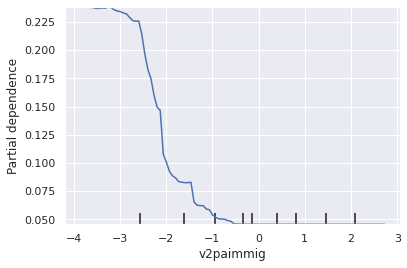

In [26]:
# Partial Dependence Plot

var_of_interest = ['v2paimmig']

PartialDependenceDisplay.from_estimator(calibrated, X_train, [var_of_interest])

In [27]:
# Alternative approach: ensuring there's no leakage by splitting on party id:

from sklearn.model_selection import GroupShuffleSplit 

splitter = GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 416)


split = splitter.split(vparty_original, groups=vparty_original['party_id'])

train_inds, test_inds = next(split)


train = vparty_original.iloc[train_inds]

test = vparty_original.iloc[test_inds]


rf.fit(train.drop(columns=['country_name', 'farright', 'party_id']), train.farright)


rf.score(test.drop(columns=['country_name', 'farright', 'party_id']), test.farright)


rf.predict_proba(bjp_variables)


array([[0.74204612, 0.25795388],
       [0.74304612, 0.25695388],
       [0.81204612, 0.18795388],
       [0.81404612, 0.18595388],
       [0.8170674 , 0.1829326 ],
       [0.8190674 , 0.1809326 ],
       [0.71711204, 0.28288796],
       [0.30951815, 0.69048185],
       [0.30159362, 0.69840638]])